<b>Project Report</b> 

**Introduction**
    
    Cardiovascular diseases kill approximately 17 million people in the world, including heart attacks, strokes, and heart failure. In particular, heart failure is caused when the heart cannot successfully send the required amount of blood to the body (Chicco, 2020), and can occur for numerous reasons such as diabetes, high blood pressure, and other heart conditions or diseases. With the emergence and accessibility of electronic health records, it is now possible to use data from patients who have experienced heart failure and find trends and patterns amongst variables that could be possible predictors for people who are at risk of heart failure. Due to the vital nature of the heart finding trends among variables as predictors of heart failure has become a priority among doctors and researchers alike. Our project was to take a data set comprised of data taken from people who had suffered from heart failure and build a classifying model that could predict a person's chance of survival after heart failure. A data set collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad contains the data of 299 patients which consisted of 105 women and 194 men who had all experienced heart failure. The dataset contained 13 features which ranged from physical, clinical, and lifestyle characteristics. This included categorical variables like sex, diabetes, and smoking; as well as numerical variables such as platelet count, serum creatine levels, and ejection fraction. This data set also contained the information on whether the patient had died in the 130 days follow-up after their heart failure referred to as a death event. Through the use of forward selection, we were able to identify two variables that were strong predictors of death events. These two variables, serum creatine and ejection fraction were used to build our classifying model that would take in the values of our predictors and classify whether this patient would experience a death event or not. This classifier would allow us to answer the question of if given a person's serum creatine levels and ejection fraction will that person survive within 130 days after their heart failure?


**Methods and Results**

Main Code Body:

In [1]:
# Loading necessary packages
library(tidyverse)
library(tidymodels)
library(repr)

# Setting the seed to ensure reproducability 
set.seed(42) 

# Setting the number of maximum rows which will be displayed whenever a data tibble needs to be outputed 
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#reads in data as well as turns relevant double columns into factors 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"

# tranforms the data variables which need to factors into the factor datatype 
heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia)) 


#creates factor levels for columns that make sense with column name, not just 0 and 1 
levels(heart_data$sex) <- c("female","male")
levels(heart_data$smoking) <- c("no","yes")
levels(heart_data$DEATH_EVENT) <- c("died","survived")
levels(heart_data$high_blood_pressure) <- c("no","yes")
levels(heart_data$diabetes) <- c("no","yes")
levels(heart_data$anaemia) <- c("no","yes")

Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



In [3]:
#splits the data into training and testing data 
heart_data_split <- initial_split(heart_data, prop = .75, strata = DEATH_EVENT)
heart_train <- training(heart_data_split)
heart_test <- testing(heart_data_split)
 
heart_train

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>
75,no,582,no,20,yes,265000,1.9,130,male,no,4,survived
50,yes,111,no,20,no,210000,1.9,137,male,no,7,survived
90,yes,47,no,40,yes,204000,2.1,132,male,yes,8,survived
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,no,1820,no,38,no,270000,1.2,139,female,no,271,died
45,no,2060,yes,60,no,742000,0.8,138,female,no,278,died
45,no,2413,no,38,no,140000,1.4,140,male,yes,280,died


In [4]:
# remove non essential columns from the dataset and only keep numerical to run forward propagation
heart_train <- heart_train %>% 
    select(-anaemia, -diabetes, -high_blood_pressure, -sex, -smoking, -time)

In [5]:
# CODE TO SELECT THE BEST PREDICTOR VARIABLES (code has been adapted from the DSCI 100 course book.) 
# (Citation is in references section)

# Evaluating which predictive variables to choose

# creating an object of names of all predictive variables called "names"
names <- colnames(heart_train %>% select(-DEATH_EVENT))

# creating an empty tibble to store the final results
accuracies <- tibble(size = integer(), 
                     model_string = character(), # this is the first argument to the "recipe" function
                     accuracy = numeric())

# creating a model specification for the classifier
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
     set_engine("kknn") %>% 
     set_mode("classification")

# creating a dataframe of all candidate k values 
k_vals <- tibble(neighbors = seq(1:10))

# creating a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train, v = 5, strata = DEATH_EVENT)

# storing the total number of predictors in object "n_total"
n_total <- length(names)

# stores the selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) %>% 
                          step_scale(all_predictors()) %>% 
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>% 
              add_recipe(heart_recipe) %>% 
              add_model(heart_spec) %>% 
              tune_grid(resamples = heart_vfold, grid = k_vals) %>% 
              collect_metrics() %>% 
              filter(.metric == "accuracy") %>% 
              summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ ejection_fraction,0.6568423
2,DEATH_EVENT ~ ejection_fraction+serum_creatinine,0.7822354
3,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium,0.7994247
4,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase,0.7774879
5,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age,0.7686957
6,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age+platelets,0.7511111


Chosen predictive variables: ejection_fraction and serum_creatinine (give reference to the research paper and mention medical significance) 

In [6]:
# selecting appropriate columns from training set and testing set
heart_train <- heart_train %>% 
    select(ejection_fraction, serum_creatinine, DEATH_EVENT)

In [7]:
set.seed(42)

# Using the variables found from forward propagation to find the best k value

final_recipe <- recipe(DEATH_EVENT ~ ejection_fraction+serum_creatinine, data = heart_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

kmin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

final_vfold <- vfold_cv(heart_train, v = 5, strata = DEATH_EVENT)

kmin_results <- workflow() %>%
    add_recipe(final_recipe) %>% 
    add_model(kmin_spec) %>% 
    tune_grid(resamples = final_vfold, grid = k_vals) %>% 
    collect_metrics()

k_min <- kmin_results %>% 
    filter(.metric == "accuracy") %>% 
    arrange(-mean) %>% 
    slice(1) %>% 
    select(neighbors, mean) %>% 
    rename(accuracy = mean)
k_min

neighbors,accuracy
<int>,<dbl>
7,0.7781818


Best K = 7, accuracy = 77.8% 

In [8]:
# Retraining with the chosen K value of 7 
set.seed(42)

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

final_fit  <- workflow() %>%
    add_recipe(final_recipe) %>% 
    add_model(final_spec) %>% 
    fit(data = heart_train)

heart_prediction <- predict(final_fit, heart_test) %>% 
    bind_cols(heart_test)

heart_prediction_accuracy <- heart_prediction %>% 
    metrics(truth = DEATH_EVENT, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7027027


In [9]:
heart_prediction_confusion <- heart_prediction %>% 
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)
heart_prediction_confusion

          Truth
Prediction died survived
  died       39       11
  survived   11       13

Explain how we only care about the 11 wrong classificationa when the the truth = died and prediction = survived as those are the people who will not get approporiate healthcare to avoid death. Hence overall critical accuracy is around 11/(39+11+11+13) ~= 84%

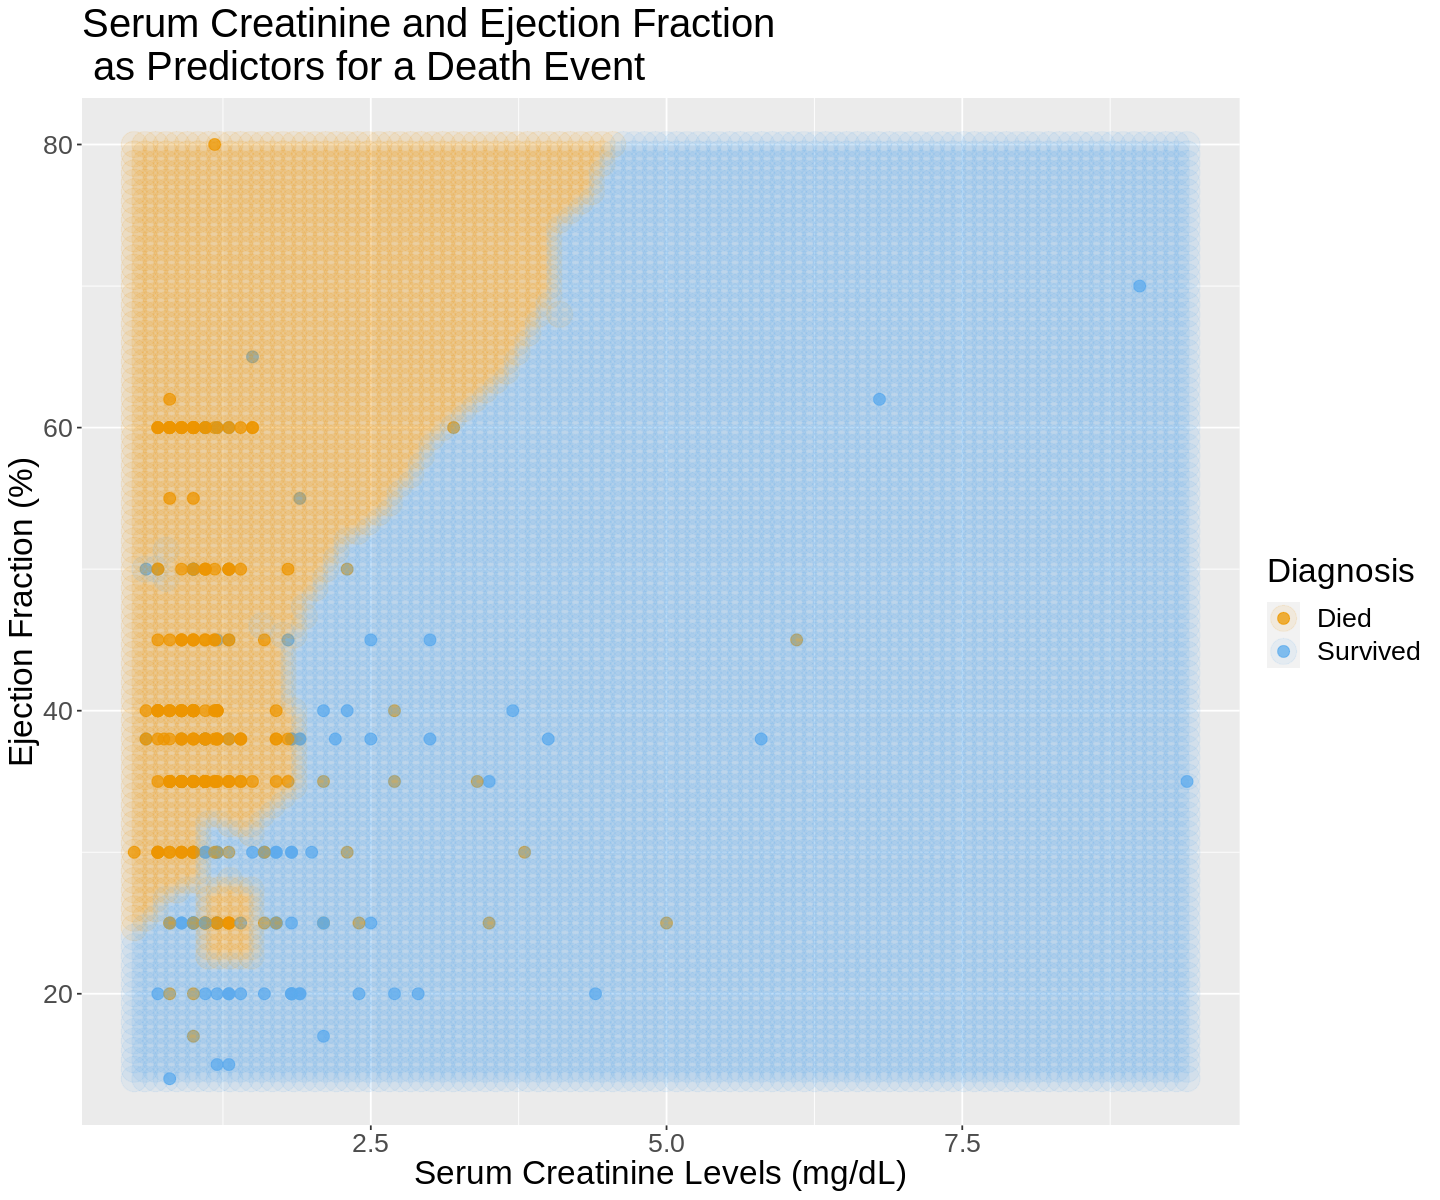

In [23]:
set.seed(42)
# Making a prediction boundry plot for the classifier 
options(repr.plot.height = 10, repr.plot.width = 12)
graph_data <- heart_data

# create the grid of area/smoothness vals, and arrange in a data frame
ef_grid <- seq(min(graph_data$ejection_fraction), 
                max(graph_data$ejection_fraction), 
                length.out = 100)
sc_grid <- seq(min(graph_data$serum_creatinine), 
                max(graph_data$serum_creatinine), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(ejection_fraction = ef_grid, 
                                serum_creatinine = sc_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(final_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
  rename(DEATH_EVENT = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
heart_prediction_plot <-
  ggplot() +
  geom_point(data = graph_data, 
             mapping = aes(x = serum_creatinine, 
                           y = ejection_fraction, 
                           color = DEATH_EVENT), 
             alpha = 0.75, 
             size = 3) +
  geom_point(data = prediction_table, 
             mapping = aes(x = serum_creatinine, 
                           y = ejection_fraction, 
                           color = DEATH_EVENT), 
             alpha = 0.09, 
             size = 7) +
  labs(color = "Diagnosis", x = "Serum Creatinine Levels (mg/dL)", y = "Ejection Fraction (%)", 
         title = "Serum Creatinine and Ejection Fraction\n as Predictors for a Death Event") +
  scale_color_manual(labels = c("Died", "Survived"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 20))

heart_prediction_plot